In [49]:
from ast import literal_eval
from copy import deepcopy
from typing import Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm

# Setup

In [50]:
QWERTY_LOW_LAYOUT: list[list[str]] = [
    ["`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "<back>"],
    ["<tab>", "q", "w", "e", "r", "t", "y", "u", "i", "o", "p", "[", "]", "\\"],
    [
        "<caps>",
        "a",
        "s",
        "d",
        "f",
        "g",
        "h",
        "j",
        "k",
        "l",
        ";",
        "'",
        "<enter>",
        "<enter>",
    ],
    [
        "<shift>",
        "<shift>",
        "z",
        "x",
        "c",
        "v",
        "b",
        "n",
        "m",
        ",",
        ".",
        "/",
        "<shift>",
        "<shift>",
    ],
    [
        "<ctrl>",
        "<alt>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<alt>",
        "<ctrl>",
    ],
]

QWERTY_HIGH_LAYOUT: list[list[str]] = [
    ["~", "!", "@", "#", "$", "%", "^", "&", "*", "(", ")", "_", "+", "<back>"],
    ["<tab>", "Q", "W", "E", "R", "T", "Y", "U", "I", "O", "P", "{", "}", "|"],
    [
        "<caps>",
        "A",
        "S",
        "D",
        "F",
        "G",
        "H",
        "J",
        "K",
        "L",
        ":",
        '"',
        "<enter>",
        "<enter>",
    ],
    [
        "<shift>",
        "<shift>",
        "Z",
        "X",
        "C",
        "V",
        "B",
        "N",
        "M",
        "<",
        ">",
        "?",
        "<shift>",
        "<shift>",
    ],
    [
        "<ctrl>",
        "<alt>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<alt>",
        "<ctrl>",
    ],
]

In [51]:
(
    len(QWERTY_HIGH_LAYOUT),
    len(QWERTY_HIGH_LAYOUT[0]),
    len(QWERTY_HIGH_LAYOUT[1]),
    len(QWERTY_HIGH_LAYOUT[2]),
    len(QWERTY_HIGH_LAYOUT[3]),
    len(QWERTY_HIGH_LAYOUT[4]),
)

(5, 14, 14, 14, 14, 11)

In [52]:
def get_buttons_set(
    low_layout: list[list[str]], high_layout: list[list[str]]
) -> set[str]:
    buttons: set[str] = set()

    for layout in [low_layout, high_layout]:
        for i in range(len(layout)):
            for btn in layout[i]:
                buttons.add(btn)

    return buttons


def get_keyboard_shape(layout: list[list[str]]) -> tuple[int, ...]:
    shape = [len(row) for row in layout]

    return tuple(shape)


BUTTONS_SET = get_buttons_set(QWERTY_LOW_LAYOUT, QWERTY_HIGH_LAYOUT)
KEYBOARD_LAYOUT_SHAPE = get_keyboard_shape(QWERTY_LOW_LAYOUT)
KEYBOARD_LAYOUT_CUMSUM_SHAPE = np.cumsum(KEYBOARD_LAYOUT_SHAPE)
KEYS = sum(KEYBOARD_LAYOUT_SHAPE) * 2

In [53]:
def get_encode_dicts() -> tuple[dict[tuple[int, int], int], dict[int, tuple[int, int]]]:
    pair_to_id = {}
    id_to_pair = {}
    counter = 0
    for i in range(134):
        for j in range(i + 1, 134):
            pair_to_id[(i, j)] = counter
            id_to_pair[counter] = (i, j)
            counter += 1
    return pair_to_id, id_to_pair


PAIR_TO_ID, ID_TO_PAIR = get_encode_dicts()
ACTION_SPACE_SIZE = len(PAIR_TO_ID)

In [54]:
ACTION_SPACE_SIZE

8911

In [55]:
def encode_decode_buttons(buttons: set[str]) -> tuple[dict[str, int], dict[int, str]]:
    letters_dict = {}
    for idx, letter in enumerate("abcdefghijklmnopqrstuvwxyz"):
        letters_dict[letter] = idx + 1

    offset = len(letters_dict)
    for idx, letter in enumerate("abcdefghijklmnopqrstuvwxyz".upper()):
        letters_dict[letter] = offset + idx + 1

    encode_value = len(letters_dict) + 1
    encode_dict = {}
    decode_dict = {}
    for btn in sorted(buttons):
        if btn in letters_dict:
            decode_dict[letters_dict[btn]] = btn
            encode_dict[btn] = letters_dict[btn]
        else:
            decode_dict[encode_value] = btn
            encode_dict[btn] = encode_value
            encode_value += 1
    return encode_dict, decode_dict


ENCODE_DICT, DECODE_DICT = encode_decode_buttons(BUTTONS_SET)
ENCODED_BUTTONS_SET = {ENCODE_DICT[btn] for btn in BUTTONS_SET}
SHIFT_CODE = ENCODE_DICT["<shift>"]

In [56]:
DECODE_DICT

{37: 'K',
 13: 'm',
 53: '<space>',
 9: 'i',
 7: 'g',
 54: "'",
 12: 'l',
 6: 'f',
 55: '>',
 56: '<shift>',
 57: '2',
 58: '4',
 59: '^',
 60: '`',
 39: 'M',
 61: ';',
 62: '<ctrl>',
 25: 'y',
 15: 'o',
 63: '-',
 64: '@',
 65: '+',
 66: '"',
 14: 'n',
 67: '[',
 68: '<',
 69: '%',
 19: 's',
 8: 'h',
 70: '!',
 26: 'z',
 71: '#',
 72: ']',
 35: 'I',
 73: '<caps>',
 27: 'A',
 18: 'r',
 4: 'd',
 74: '<back>',
 75: '=',
 76: '&',
 77: '.',
 24: 'x',
 41: 'O',
 23: 'w',
 78: '/',
 43: 'Q',
 79: '}',
 21: 'u',
 80: '<alt>',
 52: 'Z',
 47: 'U',
 20: 't',
 49: 'W',
 81: '~',
 82: '|',
 48: 'V',
 16: 'p',
 30: 'D',
 83: '\\',
 38: 'L',
 84: '0',
 85: '<enter>',
 86: ')',
 2: 'b',
 5: 'e',
 44: 'R',
 87: '7',
 36: 'J',
 88: '<tab>',
 89: '3',
 45: 'S',
 10: 'j',
 90: '$',
 33: 'G',
 91: '(',
 92: ':',
 93: ',',
 11: 'k',
 50: 'X',
 28: 'B',
 34: 'H',
 32: 'F',
 22: 'v',
 94: '{',
 1: 'a',
 51: 'Y',
 31: 'E',
 95: '9',
 96: '5',
 3: 'c',
 97: '1',
 17: 'q',
 46: 'T',
 98: '8',
 29: 'C',
 99: '6

In [57]:
for btn in BUTTONS_SET:
    assert btn == DECODE_DICT[ENCODE_DICT[btn]]

In [58]:
len(BUTTONS_SET)

102

In [59]:
Layout = list[list[int]]


def encode_layout(layout: list[list[str]]) -> Layout:
    return [[ENCODE_DICT[btn] for btn in layout[i]] for i in range(len(layout))]


def decode_layout(layout: Layout) -> list[list[str]]:
    return [[DECODE_DICT[btn] for btn in layout[i]] for i in range(len(layout))]


QWERTY_ENCODED_HIGH: Layout = encode_layout(QWERTY_HIGH_LAYOUT)
QWERTY_ENCODED_LOW: Layout = encode_layout(QWERTY_LOW_LAYOUT)

In [60]:
def get_all_buttons_encoded(high_layout: Layout, low_layout: Layout) -> list[int]:
    all_buttons = []

    for layout in (low_layout, high_layout):
        for row in layout:
            all_buttons.extend(row)
    return all_buttons


ALL_BUTTONS_ENCODED = get_all_buttons_encoded(QWERTY_ENCODED_HIGH, QWERTY_ENCODED_LOW)

In [61]:
LogType = Literal["basic"] | Literal["debug"] | Literal["error"]


class Logger:
    def __init__(self, verbose: bool = True, hide_types: list[LogType] = []) -> None:
        self.verbose = verbose
        self.hide_types = set(hide_types)

    def log(self, message: str, log_type: LogType = "basic") -> None:
        if self.verbose and log_type not in self.hide_types:
            print(message)


LOGGER = Logger()

In [62]:
Position = tuple[int, int]


class Finger:
    def __init__(
        self, initial_position: Position, name: str, logger: Logger = LOGGER
    ) -> None:
        self.name = name
        self.initial_position = initial_position

        self.logger = logger

        self.reset()

        # Constants

        self.wait_before_return = 4  # in ticks

        self.long_row_move_shift = 3
        self.long_row_move_penalty = 1

        self.row_penalty_coefficient = 1
        self.column_penalty_coefficient = 1.2

    def reset(self):
        self.current_position = self.initial_position
        self.ticks_before_return = 0  # if == 0, returns to the initial position
        self.typed_keys = 0

    def move(self, position: Position):
        self.current_position = position

        self.ticks_before_return = self.wait_before_return
        self.typed_keys += 1

    def tick(self) -> float:
        if self.ticks_before_return > 0:
            self.ticks_before_return -= 1

        if self.ticks_before_return == 0:
            score = self.get_score(self.initial_position)
            self.current_position = self.initial_position
            return score

        return 0

    def get_score(self, target_position: Position) -> float:
        x1, y1 = self.current_position
        x2, y2 = target_position

        row_distance = abs(x1 - x2) ** 2
        column_distance = abs(y1 - y2) ** 2

        penalty = 0
        if row_distance > self.long_row_move_shift:
            penalty = self.long_row_move_penalty
        return (
            row_distance * self.row_penalty_coefficient
            + column_distance * self.column_penalty_coefficient
            + penalty
        )

    def show_statistics(self):
        self.logger.log(
            f"Name: {self.name:22} \
            Typed keys: {self.typed_keys:5} \
            Ticks before return: {self.ticks_before_return:5} \
            Current position: {self.current_position}\t\
            Default position: {self.initial_position}"
        )

In [63]:
DEFAULT_FINGERS: list[Finger] = [
    Finger((2, 1), "левый мизинец"),
    Finger((2, 2), "левый безымянный"),
    Finger((2, 3), "левый средний"),
    Finger((2, 4), "левый указательный"),
    Finger((4, 3), "левый большой"),
    Finger((4, 6), "правый большой"),
    Finger((2, 7), "правый указательный"),
    Finger((2, 8), "правый средний"),
    Finger((2, 9), "правый безымянный"),
    Finger((2, 10), "правый мизинец"),
]

SwapType = Literal["low_layout"] | Literal["high_layout"] | Literal["between_layouts"]


class KeyboardLayout:
    @staticmethod
    def layout_to_dict(
        layout: Layout, unused_layout: Layout
    ) -> dict[int, list[Position]]:
        layout_dict: dict[int, list[Position]] = {}

        for i in range(len(layout)):
            for j in range(len(layout[i])):
                button = layout[i][j]
                if button in layout_dict:
                    layout_dict[button].append((i, j))
                else:
                    layout_dict[button] = [(i, j)]

        for i in range(len(unused_layout)):
            for j in range(len(unused_layout[i])):
                button = unused_layout[i][j]
                if button not in layout_dict:
                    layout_dict[button] = []

        return layout_dict

    def _finish_move(self):
        for finger in self.fingers:
            self.total_score += finger.tick()

    def __init__(self, low_layout: Layout, high_layout: Layout, logger: Logger = LOGGER):
        self.low_layout = deepcopy(low_layout)
        self.high_layout = deepcopy(high_layout)

        self.low_layout_dict = KeyboardLayout.layout_to_dict(
            self.low_layout, self.high_layout
        )
        self.high_layout_dict = KeyboardLayout.layout_to_dict(
            self.high_layout, self.low_layout
        )

        self.logger = logger

        self.fingers = deepcopy(DEFAULT_FINGERS)

        self.reset()

    def reset(self):
        self.total_score: float = 0
        self.typed_keys: int = 0
        for f in self.fingers:
            f.reset()

    def move_one_finger(
        self, positions: list[Position], busy_finger_id: Optional[int] = None
    ) -> tuple[tuple[int, Position], float]:
        best_finger_id: int = 0
        best_score = np.inf

        final_position: Position = (0, 0)

        for position in positions:
            scores = [
                finger.get_score(position) if i != busy_finger_id else np.inf
                for i, finger in enumerate(self.fingers)
            ]

            candidate_finger_id = int(np.argmin(scores))
            candidate_score = scores[candidate_finger_id]

            if candidate_score < best_score:
                best_score = candidate_score
                best_finger_id = candidate_finger_id
                final_position = position

        return (best_finger_id, final_position), best_score

    def move_two_fingers(
        self, positions: list[Position]
    ) -> tuple[tuple[int, Position], tuple[int, Position], float]:
        shift_positions = self.low_layout_dict[SHIFT_CODE]
        if len(shift_positions) == 0:
            print("ERROR SHIFT IS UNREACHABLE")
            return (0, (0, 0)), (0, (0, 0)), 9999

        # firstly reach SHIFT, then - positions
        finger_shift_info_1, shift_distance_1 = self.move_one_finger(shift_positions)
        finger_btn_info_1, d1_btn = self.move_one_finger(
            positions, finger_shift_info_1[0]
        )
        total_distance_1 = shift_distance_1 + d1_btn

        # firstly reach positions, then - SHIFT
        finger_btn_info_2, d1_btn = self.move_one_finger(positions)
        finger_shift_info_2, shift_distance_2 = self.move_one_finger(
            shift_positions, finger_btn_info_2[0]
        )
        total_distance_2 = shift_distance_2 + d1_btn

        if total_distance_1 < total_distance_2:
            return finger_btn_info_1, finger_shift_info_1, total_distance_1

        return finger_btn_info_2, finger_shift_info_2, total_distance_2

    def find_button(self, button: int):
        if button in self.low_layout_dict and len(self.low_layout_dict[button]) > 0:
            (finger_id, finger_position), score = self.move_one_finger(
                self.low_layout_dict[button]
            )

            self.fingers[finger_id].move(finger_position)
            self.total_score += score
            self.typed_keys += 1

            self.logger.log(f"{button}:\t{self.fingers[finger_id].name}")

        elif button in self.high_layout_dict and len(self.high_layout_dict[button]) > 0:
            (
                (finger_id_1, finger_position_1),
                (finger_id_2, finger_position_2),
                score,
            ) = self.move_two_fingers(self.high_layout_dict[button])

            self.fingers[finger_id_1].move(finger_position_1)
            self.fingers[finger_id_2].move(finger_position_2)
            self.total_score += score
            self.typed_keys += 2

            self.logger.log(
                f"{button}:\t{self.fingers[finger_id_1].name} + {self.fingers[finger_id_2].name}"
            )

        else:
            self.logger.log(f"NO SUCH KEY: {button}")

        self._finish_move()

    def type_text(self, text: list[str]) -> float:
        for button in text:
            self.find_button(ENCODE_DICT[button])
        return self.total_score

    def type_encoded_text(self, encoded_text: list[int]) -> float:
        for button in encoded_text:
            self.find_button(button)
        return self.total_score

    def swap_buttons(self, position1: Position, position2: Position, swap_type: SwapType):
        if swap_type == "high_layout":
            layout_from = layout_to = self.high_layout
            layout_from_dict = layout_to_dict = self.high_layout_dict
        elif swap_type == "low_layout":
            layout_from = layout_to = self.low_layout
            layout_from_dict = layout_to_dict = self.low_layout_dict
        else:  # swap_type == "between_layouts"
            layout_from = self.low_layout
            layout_to = self.high_layout
            layout_from_dict = self.low_layout_dict
            layout_to_dict = self.high_layout_dict

        x1, y1 = position1
        btn1 = layout_from[x1][y1]
        x2, y2 = position2
        btn2 = layout_to[x2][y2]

        layout_from[x1][y1], layout_to[x2][y2] = layout_to[x2][y2], layout_from[x1][y1]

        layout_from_dict[btn1].remove(position1)
        layout_to_dict[btn2].remove(position2)

        layout_from_dict[btn2].append(position1)
        layout_to_dict[btn1].append(position2)

    def decode_layouts(self) -> tuple[list[list[str]], list[list[str]]]:
        return (decode_layout(self.low_layout), decode_layout(self.high_layout))

    def get_string_layouts(self) -> str:
        low_layout, high_layout = self.decode_layouts()
        result_string = "High layout:\n"
        for row in high_layout:
            for s in row:
                result_string += f"{s:8}"
            result_string += "\n"
        result_string += "\n"

        result_string += "\nLow layout:\n"
        for row in low_layout:
            for s in row:
                result_string += f"{s:8}"
            result_string += "\n"
        result_string += "\n"

        return result_string

    def show_statistics(self):
        self.logger.log("\nStatistics:")
        for f in self.fingers:
            f.show_statistics()

    def flatten(self) -> torch.Tensor:
        flatten = []
        for row in self.low_layout:
            flatten.extend(row)
        for row in self.high_layout:
            flatten.extend(row)

        flatten = [x / len(BUTTONS_SET) for x in flatten]
        return torch.as_tensor(flatten, dtype=torch.float32)

    def get_average_score(self) -> float:
        return self.total_score / self.typed_keys

# Data loading & preprocessing

In [64]:
data_points = pd.read_csv("../data/raw/encoded_programs.csv", index_col=0)
data_points.head()

,encoded_text
0,"[16, 15, 9, 14, 20, 53, 15, 16, 5, 18, 1, 20, ..."
1,"[9, 14, 20, 53, 13, 1, 9, 14, 91, 86, 53, 94, ..."
2,"[9, 14, 20, 53, 13, 1, 9, 14, 91, 86, 85, 88, ..."
3,"[9, 14, 20, 53, 13, 1, 9, 14, 91, 86, 53, 94, ..."
4,"[53, 53, 9, 14, 20, 53, 13, 1, 9, 14, 91, 86, ..."


In [65]:
dataset = np.array(
    [np.array(text) for text in data_points["encoded_text"].apply(literal_eval).to_list()]
)
dataset.shape

(10, 400)

In [66]:
LIMIT_DATA: int = 10  # use only several data points
data = dataset[:LIMIT_DATA]

## QWERTY estimation

In [68]:
qwerty_keyboard = KeyboardLayout(
    QWERTY_ENCODED_LOW, QWERTY_ENCODED_HIGH, Logger(verbose=False)
)

loop = tqdm(data)
for text in loop:
    qwerty_score_total = qwerty_keyboard.type_encoded_text(text)
    loop.set_postfix({"qwerty": qwerty_score_total})

100%|██████████| 10/10 [00:00<00:00, 31.06it/s, qwerty=1.03e+4]


In [70]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def estimate_layout(layout: KeyboardLayout, dataset: np.ndarray) -> torch.Tensor:
    score = 0
    loop = dataset
    layout.reset()
    for text in loop:
        layout.type_encoded_text(text)

    score = layout.total_score
    return torch.tensor([score]).float().unsqueeze(0).to(DEVICE)

In [71]:
def convert_int_to_coords(n: int) -> tuple[int, int, int]:
    shift = 0
    row = 0
    column = 0
    if n >= KEYS:
        return 2, 0, 0
    if n < 0:
        return 2, 0, 0
    if n >= KEYS // 2:
        n -= KEYS // 2
        shift = 1
    for i in range(len(KEYBOARD_LAYOUT_CUMSUM_SHAPE)):
        if n < KEYBOARD_LAYOUT_CUMSUM_SHAPE[i]:
            row = i
            break
    if row > 0:
        n -= KEYBOARD_LAYOUT_CUMSUM_SHAPE[row - 1]
    column = n
    return shift, row, column

# Actor Critic

In [72]:
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 5  # 500
MAX_STEPS = 100

# score agent needs for environment to be solved
SOLVED_SCORE = qwerty_score_total * 0.5

In [73]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space: int, action_space: int, hidden_dim: int = 128):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, action_space)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        actions = self.output_layer(x)
        return F.softmax(actions, dim=0)

In [74]:
class StateValueNetwork(nn.Module):
    def __init__(self, observation_space: int, hidden_dim: int = 128):
        super(StateValueNetwork, self).__init__()

        self.input_layer = nn.Linear(observation_space, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.input_layer(x))

        return self.output_layer(x)

In [75]:
def select_action(
    policy_network: nn.Module, layout: KeyboardLayout
) -> tuple[int, torch.Tensor]:
    state = layout.flatten().to(DEVICE)
    action_probabilities = policy_network(state)

    action_probabilities = Categorical(action_probabilities)
    action = action_probabilities.sample()

    return int(action.item()), action_probabilities.log_prob(action)

In [76]:
env = KeyboardLayout(QWERTY_ENCODED_LOW, QWERTY_ENCODED_HIGH, Logger(verbose=False))

policy_network = PolicyNetwork(KEYS, ACTION_SPACE_SIZE).to(DEVICE)
state_val_network = StateValueNetwork(KEYS).to(DEVICE)

policy_optimizer = optim.SGD(policy_network.parameters(), lr=1e-3)
state_val_optimizer = optim.SGD(state_val_network.parameters(), lr=1e-3)

In [77]:
best_score = qwerty_score_total
best_keyboard = env

In [78]:
# log scores
scores = []

for episode in tqdm(range(NUM_EPISODES)):
    state = KeyboardLayout(QWERTY_ENCODED_LOW, QWERTY_ENCODED_HIGH, Logger(verbose=False))
    is_done = False
    scores.append([qwerty_score_total])
    prev_reward = 0
    cumulative_discount = 1.0
    prev_states = [(state.low_layout, state.high_layout)]

    for step in range(MAX_STEPS):
        action, actions_log_probabilities = select_action(policy_network, state)

        # step with action
        btn1, btn2 = ID_TO_PAIR[action]
        cord1, cord2 = convert_int_to_coords(btn1), convert_int_to_coords(btn2)

        swap_type: SwapType = "low_layout"

        if cord2[0] == 1:
            swap_type = "between_layouts"

        if cord1[0] == 1:
            swap_type = "high_layout"

        pos1 = (cord1[1], cord1[2])
        pos2 = (cord2[1], cord2[2])
        new_state = deepcopy(state)
        new_state.swap_buttons(pos1, pos2, swap_type)

        new_score = estimate_layout(new_state, data)

        if new_score.item() < best_score:
            best_score = new_score.item()
            best_keyboard = deepcopy(new_state)

        scores[episode].append(new_score.item())
        reward = qwerty_score_total - new_score.item()

        if (new_state.low_layout, new_state.high_layout) in prev_states or reward < -1000:
            is_done = True
        else:
            is_done = False

        prev_reward = reward
        cur_score = new_score.item()

        if is_done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)

        advantage = reward / qwerty_score_total
        policy_loss = -actions_log_probabilities * advantage

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        if is_done:
            break
        state = new_state
        prev_states.append((state.low_layout, state.high_layout))
        cumulative_discount *= DISCOUNT_FACTOR

    if best_score <= SOLVED_SCORE:
        break

100%|██████████| 5/5 [00:27<00:00,  5.50s/it]


In [79]:
data

array([[16, 15,  9, ..., 12,  1,  4],
       [ 9, 14, 20, ..., 21, 18, 14],
       [ 9, 14, 20, ..., 53, 53, 53],
       ...,
       [ 9, 14, 20, ..., 53, 53, 53],
       [ 9, 14, 20, ..., 53, 53, 53],
       [ 9, 14, 20, ..., 53, 53, 53]])

In [80]:
BEST_SCORE = best_score
print(f"{BEST_SCORE=}")
print(f"{qwerty_score_total=}")

BEST_SCORE=9442.2001953125
qwerty_score_total=10272.600000000048


In [81]:
print(best_keyboard.get_string_layouts())

High layout:
~       !       @       ^       $       u       #       h       *       (       )       2       +       <back>  
<tab>   Q       W       E       R       T       Y       U       I       O       P       {       }       |       
<caps>  A       S       D       1       -       H       J       K       L       :       <space> <enter> <enter> 
<shift> <shift> Z       X       _       V       B       N       M       <       >       ?       <shift> <shift> 
<ctrl>  <alt>   <space> <space> <space> <space> <space> <space> <space> <alt>   <ctrl>  


Low layout:
`       F       C       3       4       5       6       7       8       9       0       G       =       <back>  
<tab>   q       w       e       r       <space> y       %       i       o       ,       [       ]       \       
<caps>  a       s       b       f       g       &       <shift> k       l       ;       '       <enter> <enter> 
<shift> <shift> z       x       /       v       d       n       m       p       .       c    

# Visualization

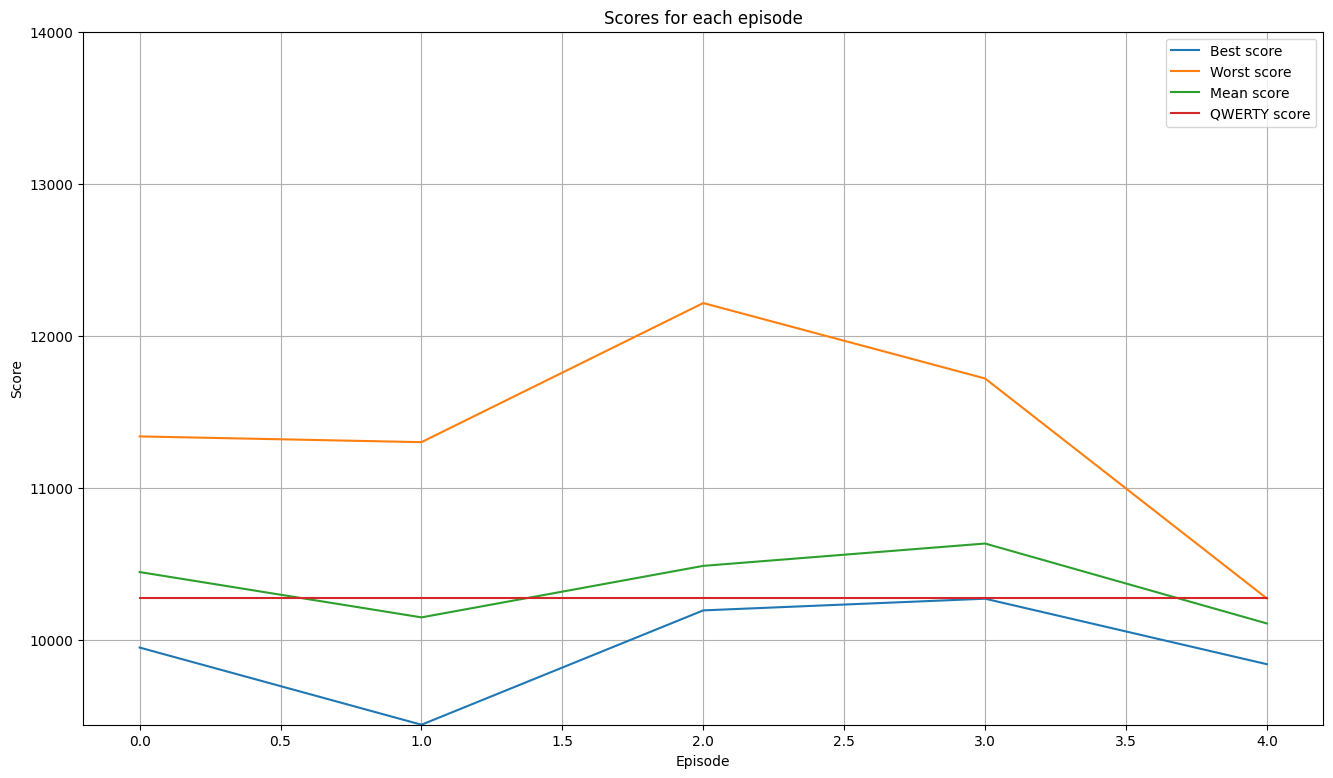

In [82]:
def plot_scores(scores: list[float], figsize: tuple[int, int] = (16, 9)):
    best_scores = [min(x) for x in scores]
    worst_scores = [max(x) for x in scores]
    mean_scores = [np.mean(x) for x in scores]
    qwerty_scores = [x[0] for x in scores]

    plt.subplots(1, 1, figsize=figsize)
    plt.plot(best_scores, label="Best score")
    plt.plot(worst_scores, label="Worst score")
    plt.plot(mean_scores, label="Mean score")
    plt.plot(qwerty_scores, label="QWERTY score")

    plt.legend()
    plt.grid()
    # plt.xlim([0, 500])
    plt.ylim([best_score, 14000])
    plt.ylabel("Score")
    plt.xlabel("Episode")
    plt.title("Scores for each episode")
    plt.show()


plot_scores(scores)

In [83]:
qwerty_score_total

10272.600000000048

In [84]:
scores

[[10272.600000000048,
  10272.599609375,
  9949.7998046875,
  9962.7998046875,
  10367.2001953125,
  10367.2001953125,
  10367.2001953125,
  11118.7998046875,
  11338.400390625],
 [10272.600000000048,
  10288.599609375,
  10232.599609375,
  9836.400390625,
  9836.0,
  10086.599609375,
  9655.7998046875,
  9625.400390625,
  9757.400390625,
  9781.2001953125,
  9749.2001953125,
  9749.2001953125,
  9466.7998046875,
  9442.2001953125,
  9444.599609375,
  9485.599609375,
  9494.0,
  9591.599609375,
  9557.400390625,
  9557.400390625,
  9950.2001953125,
  9937.0,
  9812.0,
  9868.0,
  9656.7998046875,
  9656.7998046875,
  10374.2001953125,
  10402.0,
  10424.599609375,
  10587.7998046875,
  10587.7998046875,
  10578.2001953125,
  10574.599609375,
  10546.599609375,
  10460.2001953125,
  10509.400390625,
  10539.599609375,
  10608.7998046875,
  10831.7998046875,
  10804.2001953125,
  10880.7998046875,
  10926.0,
  10926.0,
  11014.400390625,
  11300.599609375],
 [10272.600000000048,
  10194.